## Transformer

In [1]:
import tensorflow as tf
import pandas as pd
import os

if len(tf.config.list_physical_devices('GPU')):
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### Data

In [2]:
from data_getter import *

30220 summaries containing 'No summary available'
6142 summaries containing 'Full story available on'
Duplicate summaries removed: 14242
Duplicate headlines removed: 404
randomizing order of data


In [3]:
import numpy as np
max_len = np.array([len(sentence.split(" ")) for sentence in balanced_dataset.summary])
np.max(max_len)

496

(array([32900.,     0.,     0.,     0.,     0., 32900.,     0.,     0.,
            0., 32900.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

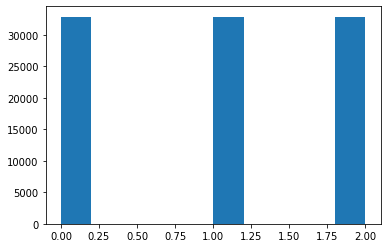

In [4]:
import matplotlib.pyplot as plt
plt.hist(balanced_dataset.priceChangeClass)

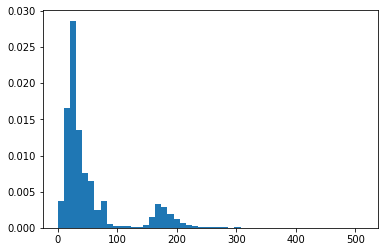

In [5]:
plot = plt.hist(sorted(max_len), bins=50, density=True, range=[0,512])

As can be seen from the graph, a sequence length of 256 captures the majority of features. 
To be exact:

In [6]:
np.count_nonzero(max_len <= 256) / len(max_len)

0.99596757852077

### Tokenizer

In [7]:
from transformers import BertTokenizer, TFBertForSequenceClassification,DistilBertTokenizer

#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)
#model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")


In [8]:
#model.summary()

In [9]:
tokenized = tokenizer.tokenize(train_data.iloc[1].summary)
print(tokenized)
input_ids = tokenizer.convert_tokens_to_ids(tokenized)
print(input_ids)

['the', 'stock', 'tumbled', 'over', '4', 'per', 'cent', 'to', 'rs', '119', '.', '30', 'on', 'the', 'bs', '##e', '.']
[1996, 4518, 18303, 2058, 1018, 2566, 9358, 2000, 12667, 13285, 1012, 2382, 2006, 1996, 18667, 2063, 1012]


In [10]:
def convert_to_bert_input(df, tokenizer):
    res = []
    
    for index,row in df.iterrows():
        if index % 5000 == 0:
            print(index/len(df.index)*100)
        input_dict = tokenizer.encode_plus(
                row.summary,
                add_special_tokens=True,
                max_length= 256, # truncates if len(s) > max_length
                return_token_type_ids=True,
                return_attention_mask=True,
                truncation=True
            )
        res.append(input_dict["input_ids"])
    return np.array(res)


def transform_input(df):
    return tokenizer.batch_encode_plus(
            df.summary,
            return_tensors='tf',
            add_special_tokens=True,
            max_length= 256, # truncates if len(s) > max_length
            return_token_type_ids=True,
            padding='max_length',
            truncation=True)

def transform_input2(df):
    return tokenizer(df.summary.tolist(), 
                     truncation=True, 
                     padding=True, 
                     max_length=256,
                     return_tensors="tf")

In [11]:
#x_train_trans = convert_to_bert_input(train_data, tokenizer)
#x_valid_trans = convert_to_bert_input(validation_data, tokenizer)

train_data.summary

0        Portland General Electric (NYSE:POR) – KeyCorp...
1        The stock tumbled over 4 per cent to Rs 119.30...
2        Leslie Wexner is the CEO of L Brands, which in...
3        NORFOLK, Neb.--(BUSINESS WIRE)---- $CDOR #Hote...
4        From Louis Vuitton luggage to a watch that pro...
                               ...                        
71059    Growing Ethereum network transaction fees, whi...
71060    BAE Systems will produce multiple types of Ver...
71061    HARRISBURG, Pa., Dec. 5, 2019 /PRNewswire/ -- ...
71062    Skechers (SKX) shuts company-owned retail stor...
71063    Wheaton Precious Metals (NYSE: WPM) shares are...
Name: summary, Length: 71064, dtype: object

In [12]:
#train_data.summary.tolist()

In [13]:
x_tmp = validation_data#.sample(n=1000)
x_valid_trans = transform_input2(x_tmp)

In [14]:
xtr_tmp = train_data#.sample(n=5000)
x_train_trans = transform_input2(xtr_tmp)

In [15]:
x_train_trans

{'input_ids': <tf.Tensor: shape=(71064, 256), dtype=int32, numpy=
array([[  101,  6734,  2236, ...,     0,     0,     0],
       [  101,  1996,  4518, ...,     0,     0,     0],
       [  101,  8886,  2057, ...,     0,     0,     0],
       ...,
       [  101, 24569,  1010, ...,     0,     0,     0],
       [  101, 15315, 27635, ...,     0,     0,     0],
       [  101, 10500,  2239, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(71064, 256), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [16]:
#x_train_dataset = dataset = tf.data.Dataset.from_tensor_slices((dict(x_train_trans['input_ids'],
#                                              x_train_trans['attention_mask'],
#                                              x_train_trans['token_type_ids']), y_train))
#x_valid_dataset = dataset = tf.data.Dataset.from_tensor_slices((x_valid_trans['input_ids'],
#                                              x_valid_trans['attention_mask'],
#                                              x_valid_trans['token_type_ids'], val_y))
out_x_valid = np.array(x_tmp.priceChangeClass.tolist()).reshape((len(x_tmp),))
out_x_train = np.array(xtr_tmp.priceChangeClass.tolist()).reshape((len(xtr_tmp),))

x_valid_dataset = tf.data.Dataset.from_tensor_slices((dict(x_valid_trans), out_x_valid))
x_train_dataset = tf.data.Dataset.from_tensor_slices((dict(x_train_trans), out_x_train))

In [17]:
len(x_train_dataset)

71064

In [18]:
print(len(x_valid_dataset), x_valid_dataset)
x_valid_dataset
#x_valid_dataset.apply()

9870 <TensorSliceDataset shapes: ({input_ids: (256,), attention_mask: (256,)}, ()), types: ({input_ids: tf.int32, attention_mask: tf.int32}, tf.int64)>


<TensorSliceDataset shapes: ({input_ids: (256,), attention_mask: (256,)}, ()), types: ({input_ids: tf.int32, attention_mask: tf.int32}, tf.int64)>

In [19]:
from transformers import TFDistilBertForSequenceClassification, TFPreTrainedModel

num_classes = len(set(balanced_dataset.priceChangeClass))

#model = TFDistilBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
#model = TFPreTrainedModel.from_pretrained('distilbert-base-uncased', num_labels=3)
model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_classes)

print(num_classes)



Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_transform', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

3


In [21]:
model.distilbert.return_dict = False

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, 
              loss=loss, 
              metrics=tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32))
batch_size = 3
history = model.fit(x_train_dataset.batch(batch_size), 
              epochs=1, 
              batch_size=batch_size, 
              validation_data=x_valid_dataset.batch(batch_size))

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


 2719/23688 [==>...........................] - ETA: 55:02 - loss: 1.1034 - accuracy: 0.3301

KeyboardInterrupt: 

In [90]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
_________________________________________________________________
pre_classifier (Dense)       multiple                  590592    
_________________________________________________________________
classifier (Dense)           multiple                  2307      
_________________________________________________________________
dropout_19 (Dropout)         multiple                  0         
Total params: 66,955,779
Trainable params: 66,955,779
Non-trainable params: 0
_________________________________________________________________


In [18]:
"""def build_classifier_model(num_classes):
  inputs = dict(
      input_word_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32),
      input_mask=tf.keras.layers.Input(shape=(None,), dtype=tf.int32),
      input_type_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32),
  )

  net = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)
  net = tf.keras.layers.Dense(num_classes,  name='classifier')(net)

  return tf.keras.Model(inputs, net, name='prediction')
model = build_classifier_model(3)"""

"def build_classifier_model(num_classes):\n  inputs = dict(\n      input_word_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32),\n      input_mask=tf.keras.layers.Input(shape=(None,), dtype=tf.int32),\n      input_type_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32),\n  )\n\n  net = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)\n  net = tf.keras.layers.Dense(num_classes,  name='classifier')(net)\n\n  return tf.keras.Model(inputs, net, name='prediction')\nmodel = build_classifier_model(3)"

In [19]:
#net = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)
#model = tf.keras.layers.Dense(3)(net)

In [162]:
i = next(iter(x_train_dataset))[0]
i["input_ids"] = tf.reshape(i["input_ids"],(1,256))
i["attention_mask"] = tf.reshape(i["attention_mask"],(1,256))

#print(i)

tf_output = model.predict(i)
print(type(tf_output))
print(tf_output.logits)
tf_prediction = tf.nn.softmax(tf_output.logits, axis=1).numpy()
print(tf_prediction)

<class 'transformers.modeling_tf_outputs.TFSequenceClassifierOutput'>
[[-0.3038873   0.14581959  0.02287905]]
[[0.25288734 0.39649007 0.3506226 ]]


In [29]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
_________________________________________________________________
pre_classifier (Dense)       multiple                  590592    
_________________________________________________________________
classifier (Dense)           multiple                  2307      
_________________________________________________________________
dropout_19 (Dropout)         multiple                  0         
Total params: 66,955,779
Trainable params: 66,955,779
Non-trainable params: 0
_________________________________________________________________


## --------------

In [6]:
!pip freeze | grep transformers

transformers==4.1.1


In [7]:
max_length_test = 256
test_sentence = 'Test tokenization sentence. Followed by another sentence'

In [8]:
test_text = "ValuEngine upgraded shares of Skechers USA (NYSE:SKX) from a hold rating to a buy rating in a research note issued to investors on Saturday morning,"
tokenized = tokenizer.tokenize(test_text)
print('tokenized', tokenized)

# convert tokens to ids in WordPiece
input_ids = tokenizer.convert_tokens_to_ids(tokenized)
  
# precalculation of pad length, so that we can reuse it later on
padding_length = max_length_test - len(input_ids)

# map tokens to WordPiece dictionary and add pad token for those text shorter than our max length
input_ids = input_ids + ([0] * padding_length)

# attention should focus just on sequence with non padded tokens
attention_mask = [1] * len(input_ids)

# do not focus attention on padded tokens
attention_mask = attention_mask + ([0] * padding_length)

# token types, needed for example for question answering, for our purpose we will just set 0 as we have just one sequence
token_type_ids = [0] * max_length_test
bert_input = {
    "token_ids": input_ids,
    "token_type_ids": token_type_ids,
    "attention_mask": attention_mask
} 
print(bert_input)

tokenized ['value', '##ng', '##ine', 'upgraded', 'shares', 'of', 'sk', '##eche', '##rs', 'usa', '(', 'ny', '##se', ':', 'sk', '##x', ')', 'from', 'a', 'hold', 'rating', 'to', 'a', 'buy', 'rating', 'in', 'a', 'research', 'note', 'issued', 'to', 'investors', 'on', 'saturday', 'morning', ',']
{'token_ids': [3643, 3070, 3170, 9725, 6661, 1997, 15315, 27635, 2869, 3915, 1006, 6396, 3366, 1024, 15315, 2595, 1007, 2013, 1037, 2907, 5790, 2000, 1037, 4965, 5790, 1999, 1037, 2470, 3602, 3843, 2000, 9387, 2006, 5095, 2851, 1010, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [24]:
bert_input = tokenizer.encode_plus(
                        test_sentence,                      
                        add_special_tokens = True, # add [CLS], [SEP]
                        max_length = max_length_test, # max length of the text that can go to BERT
                        pad_to_max_length = True, # add [PAD] tokens
                        return_attention_mask = True, # add attention mask to not focus on pad tokens
              )
print('encoded', bert_input)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


encoded {'input_ids': [101, 3231, 19204, 3989, 6251, 1012, 2628, 2011, 2178, 6251, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

/home/hugo/.virtualenvs/stock-news/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2173: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [28]:
import os 

import tensorflow as tf

if len(tf.config.list_physical_devices('GPU')):
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Train model

In [ ]:
from transformers import TFBertForSequenceClassification
import tensorflow as tf

# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
learning_rate = 2e-5
# we will do just 1 epoch for illustration, though multiple epochs might be better as long as we will not overfit the model
number_of_epochs = 1

# model initialization
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

# optimizer Adam recommended
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)

# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
bert_history = model.fit(ds_train_encoded, epochs=number_of_epochs, validation_data=ds_test_encoded)